In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import sys  
sys.path.insert(0, '../../..')

from hnn.simulation.mve_ensemble import MveEnsembleHamiltonianDynamics
from hnn.utils import integrate_model
from hnn.train import train
from hnn.types import TrajectoryArgs

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=300, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=1000, type=int, help='number of gradient steps')
    parser.add_argument('--field_type', default='conservative', type=str, help='type of vector field to learn') # solenoidal, conservative
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

In [3]:
from hnn.simulation.mve_ensemble.mve_ensemble import mve_ensemble_fn, get_initial_conditions

state, masses = get_initial_conditions(3)

# Hamiltonian for the ensemble
H = mve_ensemble_fn(state, masses)
print("Hamiltonian (Total Energy):", H.item())

Hamiltonian (Total Energy): 8.643030166625977


In [4]:
N_BODIES = 15
hamiltonian = MveEnsembleHamiltonianDynamics(n_bodies=N_BODIES)
r, v, dr, dv, time = hamiltonian.get_trajectory({})
positions = r.transpose(0, 1)
momentums = v.transpose(0, 1)
num_timepoints = len(time)

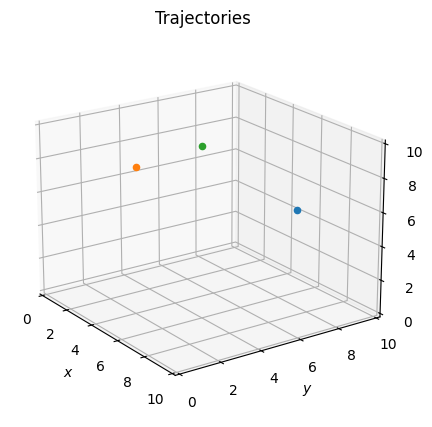

In [5]:
fig = plt.figure(figsize=[7, 5], dpi=100)
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20., azim=-35, roll=0)

splot = ax.scatter([], [], [])

def update(frame):
    ax.clear()
    ax.set_title('Trajectories')
    ax.set_xlim(*hamiltonian.domain)
    ax.set_ylim(*hamiltonian.domain)
    ax.set_zlim(*hamiltonian.domain)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    for i in range(positions.shape[0]):
        x, y, z = positions[i, frame, 0], positions[i, frame, 1], positions[i, frame, 2]
        ax.scatter(x.item(), y.item(), z.item())
    return []

ani = FuncAnimation(fig, update, frames=num_timepoints, blit=True, repeat=False) # init_func=init, 

from IPython.display import HTML
HTML(ani.to_jshtml())

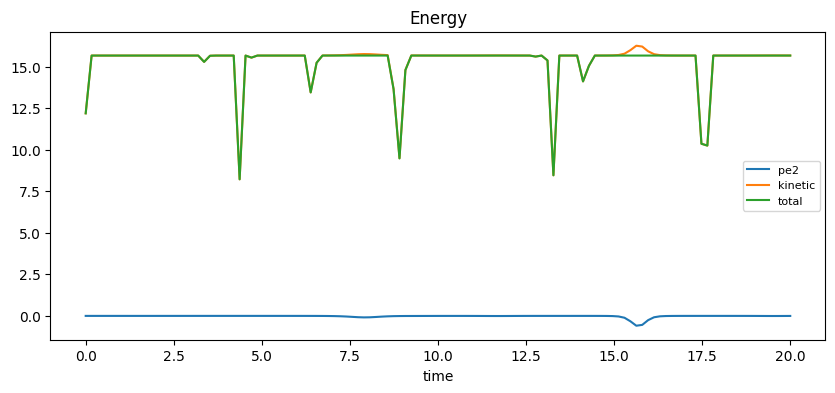

In [6]:
from hnn.simulation.mve_ensemble.mve_ensemble import calc_lennard_jones_potential, calc_kinetic_energy
# pe1 = hamiltonian.potential_fn(positions)
pe = hamiltonian.ok_potential_fn(positions)
ke = calc_kinetic_energy(momentums, hamiltonian.masses)
te = pe + ke

fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title('Energy') ; plt.xlabel('time')
# plt.plot(time, pe1, label='pe1')
plt.plot(time, pe, label='pe2')
plt.plot(time, ke, label='kinetic')
plt.plot(time, te, label='total')
plt.legend(fontsize=8)


In [7]:
args = get_args()

# data = hamiltonian.get_dataset({}, {})
# model, stats = train(args, data)